# 2.03e - Analysis of COB Peaks Overnight
This notebook identifies and analyises the peaks of carbohydrate intake (COB) during the overnight period, specifically between 22:00 and 06:00 the following day, for it to be included in the objective function. The analysis will focus on the number of peaks and their timing.

In [81]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time

from src.cob_analysis import Cob
from src.config import PROCESSED_DATA_DIR
from src.nights import Nights, consolidate_df_from_nights
from src.features import FeatureSet
from src.helper import normalise_overnight_time


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
df_all = pd.read_parquet(PROCESSED_DATA_DIR / 'night_clusters.parquet')
df_all['time'] = df_all.index.get_level_values('datetime').time

night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []
for zip_id, df_ind in df_all.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)

Previous steps in the pre-processing workflow have dealt with missing values in the 'cob max' variable. This is important given what we understand from the lifecylce of COB data in that the patient will enter a value of their intake, and the system will then deprecate the value over time based on a pre-defined rate, personalised to the patient. If there is a missing reading in the deprecation slope (and we know NaNs to be more prevalent with COB than the IOB and BG variables), and these are due to equipment or signal error for instance, two peaks will be recorded where there should be only one, leading to an overestimation of the number of peaks.

In [83]:
features = FeatureSet(df_overnight, sample_rate=sample_rate)
features.add_cob_peaks()
df_with_peaks = features.get_full_df()
df_with_peaks['cob_peaks'].value_counts()

cob_peaks
0    14319
1      286
Name: count, dtype: int64

In [84]:
peaks_summarised = df_with_peaks.groupby(['cluster', 'time']).agg({'cob_peaks': 'sum', 'cob max': 'mean'})
peaks_summarised = peaks_summarised.reset_index()
peaks_summarised['time'] = peaks_summarised['time'].apply(lambda x: normalise_overnight_time(x, morning_end.hour))
peaks_summarised.set_index(['cluster', 'time'], inplace=True)

In [89]:
import matplotlib.dates as mdates

cluster_peak_cob_means = df_with_peaks[df_with_peaks['cob_peaks']==1].groupby('cluster')['cob max'].mean().reset_index()

In [90]:
cluster_peak_cob_means

,cluster,cob max
0,0,26.607143
1,1,27.890411
2,2,42.453125
3,3,22.432432


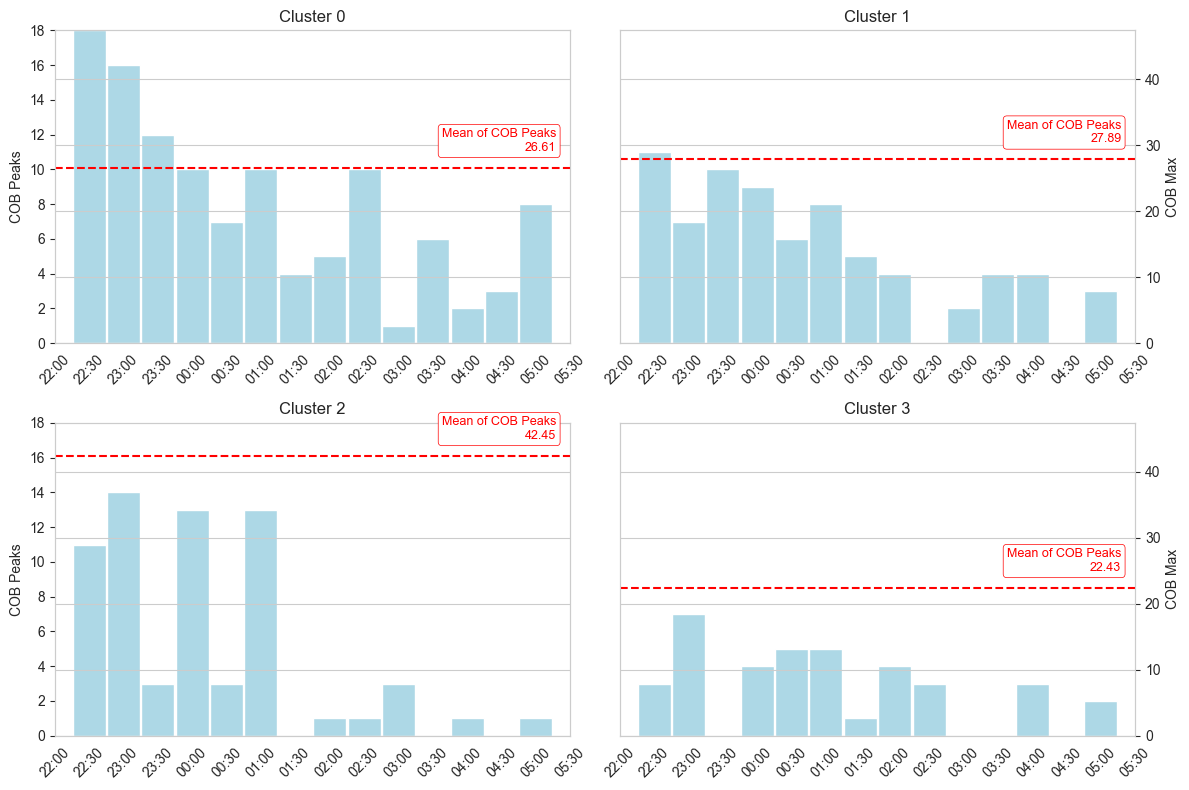

In [117]:
# Add a dashed horizontal line for each plot showing the cluster's mean COB Max from cluster_peak_cob_means
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

cob_max_lim = cluster_peak_cob_means['cob max'].max()+5
cob_min_lim = 0
peak_max_lim = peaks_summarised['cob_peaks'].max()
peak_min_lim = 0

for i, (cluster_num, cluster_data) in enumerate(peaks_summarised.groupby('cluster')):
    ax1 = axes[i]
    cluster_data.reset_index(inplace=True)

    if not cluster_data.empty:
        ax1.bar(cluster_data['time'], cluster_data['cob_peaks'], color='lightblue',
                width=0.02, zorder=1, label='COB Peaks')
        ax1.set_ylabel('COB Peaks')
        ax1.set_ylim(peak_min_lim, peak_max_lim)
        ax1.grid(False)

        ax2 = ax1.twinx()
        # Remove lineplot, only show secondary axis with horizontal mean line
        ax2.set_ylabel('COB Max')
        ax2.set_ylim(cob_min_lim, cob_max_lim)

        cluster_mean = cluster_peak_cob_means.loc[cluster_peak_cob_means['cluster'] == cluster_num, 'cob max'].values
        if len(cluster_mean) > 0:
            ax2.axhline(cluster_mean[0], color='red', linestyle='--', linewidth=1.5, label='Mean of COB Peaks')
            ax2.annotate(f"Mean of COB Peaks\n{cluster_mean[0]:.2f}",
                         xy=(cluster_data['time'].max(), cluster_mean[0]),
                         xytext=(-10, 10), textcoords='offset points',
                         va='bottom', ha='right', color='red', fontsize=9,
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=0.5))
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
        ax1.set_xlim(cluster_data['time'].min(), cluster_data['time'].max())
        ax1.tick_params(axis='x', rotation=45)


        if i % 2 != 0:
            ax1.set_ylabel('')
            ax1.tick_params(axis='y', left=False, labelleft=False)
        if i % 2 == 0:
            ax2.set_ylabel('')
            ax2.tick_params(axis='y', right=False, labelright=False)

    ax1.set_title(f'Cluster {cluster_num}')

plt.tight_layout()
plt.show()